## Predicting Damage with Logistic Regression

**Goal**: Build a classification model that will predict whether a building will be severely damagaed or not severely damaged. 

In [8]:
import sqlite3

import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import seaborn as sns 
from category_encoders import  OneHotEncoder
from sklearn.linear_model import  LogisticRegression
from sklearn.metrics import  accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.utils.validation import check_is_fitted

#### Prepare Data

Import

1. Using a function to import from an sqlite database

In [9]:
def wrangle(db_path):
    # Connect to database
    conn = sqlite3.connect(db_path)

    # Construct query
    query = """
        SELECT distinct(i.building_id) AS b_id,
           s.*,
           d.damage_grade
        FROM id_map AS i
        JOIN building_structure AS s ON i.building_id = s.building_id
        JOIN building_damage AS d ON i.building_id = d.building_id
        WHERE district_id = 4
    """

    # Read query results into DataFrame
    df = pd.read_sql(query, conn, "b_id")

    
    return df

In [ ]:
df = wrangle("/home/jovyan/nepal.sqlite")
df.head()

2. Importing csv file as pd DataFrame

In [36]:
df = pd.read_csv("data/df.csv").set_index("b_id")
df.head()

,building_id,count_floors_pre_eq,count_floors_post_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,height_ft_post_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,condition_post_eq,superstructure,damage_grade
b_id,,,,,,,,,,,,,,,,,
164002,164002,3,3,20,560,18,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Damaged-Repaired and used,Stone,Grade 2
164081,164081,2,2,21,200,12,12,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Damaged-Used in risk,Stone,Grade 2
164089,164089,3,3,18,315,20,20,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Damaged-Used in risk,Stone,Grade 2
164098,164098,2,2,45,290,13,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Damaged-Used in risk,Stone,Grade 3
164103,164103,2,2,21,230,13,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Damaged-Used in risk,Stone,Grade 3


Drop Features from the df (Drop Leaky features)

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70836 entries, 164002 to 234835
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   building_id             70836 non-null  int64 
 1   count_floors_pre_eq     70836 non-null  int64 
 2   count_floors_post_eq    70836 non-null  int64 
 3   age_building            70836 non-null  int64 
 4   plinth_area_sq_ft       70836 non-null  int64 
 5   height_ft_pre_eq        70836 non-null  int64 
 6   height_ft_post_eq       70836 non-null  int64 
 7   land_surface_condition  70836 non-null  object
 8   foundation_type         70836 non-null  object
 9   roof_type               70836 non-null  object
 10  ground_floor_type       70836 non-null  object
 11  other_floor_type        70836 non-null  object
 12  position                70836 non-null  object
 13  plan_configuration      70836 non-null  object
 14  condition_post_eq       70836 non-null  object
 15  s

Remove features that will give the model info whether the building suffered earthquake damage:

In [38]:
# The 3 columns with post-earthquake info
for col in df.columns:
    if "post_eq" in col:
        print(col)

count_floors_post_eq
height_ft_post_eq
condition_post_eq


In [39]:
# The 3 columns with post-earthquake info
drop_cols =[col for col in df.columns if "post_eq" in col]
drop_cols


['count_floors_post_eq', 'height_ft_post_eq', 'condition_post_eq']

In [40]:
df.drop(columns=drop_cols, inplace=True)
df.head()

,building_id,count_floors_pre_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,superstructure,damage_grade
b_id,,,,,,,,,,,,,,
164002,164002,3,20,560,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Stone,Grade 2
164081,164081,2,21,200,12,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Stone,Grade 2
164089,164089,3,18,315,20,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Stone,Grade 2
164098,164098,2,45,290,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Stone,Grade 3
164103,164103,2,21,230,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Stone,Grade 3


In [41]:
# Assert column drops
assert (
    df.filter(regex="post_eq").shape[1] == 0
), "`df` still has leaky features. Try again!"

Binary Classification Feature: ```severe_damage```

- For buildings where the ```damage_grade``` is Grade 4 or above, ```severe_damage``` is 1, and 0 for all other categories. 
- Next step is to drop the ```damage_grade``` column to avoid leakage.

In [42]:
df["damage_grade"].value_counts()

damage_grade
Grade 5    24869
Grade 4    20650
Grade 3    14097
Grade 2     7650
Grade 1     3570
Name: count, dtype: int64

In [45]:
df["damage_grade"]=df["damage_grade"].str[-1].astype(int)

In [48]:
print(df["damage_grade"].value_counts())

damage_grade
5    24869
4    20650
3    14097
2     7650
1     3570
Name: count, dtype: int64


In [55]:
df["severe_damage"]=(df["damage_grade"] > 3).astype(int)

In [60]:
df.drop(columns="damage_grade", inplace=True)

In [61]:
df.head()

,building_id,count_floors_pre_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,superstructure,severe_damage
b_id,,,,,,,,,,,,,,
164002,164002,3,20,560,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Stone,0
164081,164081,2,21,200,12,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Stone,0
164089,164089,3,18,315,20,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Stone,0
164098,164098,2,45,290,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Stone,0
164103,164103,2,21,230,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Stone,0


Assert column

In [81]:
print(df["severe_damage"].value_counts())

severe_damage
1    45519
0    25317
Name: count, dtype: int64


In [82]:
assert (
    "damage_grade" not in df.columns
), "Your DataFrame should not include the `'damage_grade'` column."
assert (
    "severe_damage" in df.columns
), "Your DataFrame is missing the `'severe_damage'` column."
assert (
    df["severe_damage"].value_counts().shape[0] == 2
), f"The `'damage_grade'` column should have only two unique values, not {df['severe_damage'].value_counts().shape[0]}"

### Explore

Correlation Heatmap

In [83]:
correlation = df.select_dtypes("number").drop(columns="severe_damage").corr().round(4)
correlation

,building_id,age_building,plinth_area_sq_ft,height_ft_pre_eq
building_id,1.0000,0.0095,0.0901,0.0171
age_building,0.0095,1.0000,-0.0169,0.0477
plinth_area_sq_ft,0.0901,-0.0169,1.0000,0.2835
height_ft_pre_eq,0.0171,0.0477,0.2835,1.0000


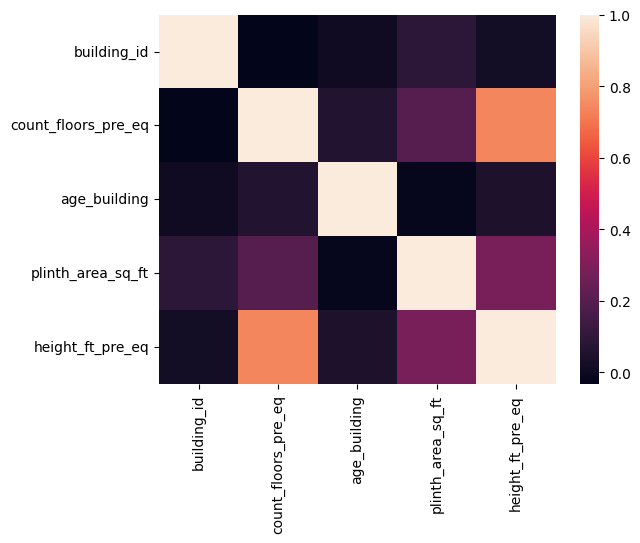

In [70]:
sns.heatmap(correlation);

Dropping columns that are highly correlated.

The first step is to check the correlation between these variables and the target variable:

In [71]:
df["severe_damage"].corr(df["count_floors_pre_eq"])

0.0028926303725752113

In [73]:
df["severe_damage"].corr(df["height_ft_pre_eq"])

-0.03847659083302046

Decision: drop "count_floors_pre_eq" because it has a lower correlation with the target.

In [74]:
df.drop(columns="count_floors_pre_eq", inplace=True)

In [75]:
df.head(3)

,building_id,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,superstructure,severe_damage
b_id,,,,,,,,,,,,,
164002,164002,20,560,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Stone,0
164081,164081,21,200,12,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Stone,0
164089,164089,18,315,20,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Stone,0


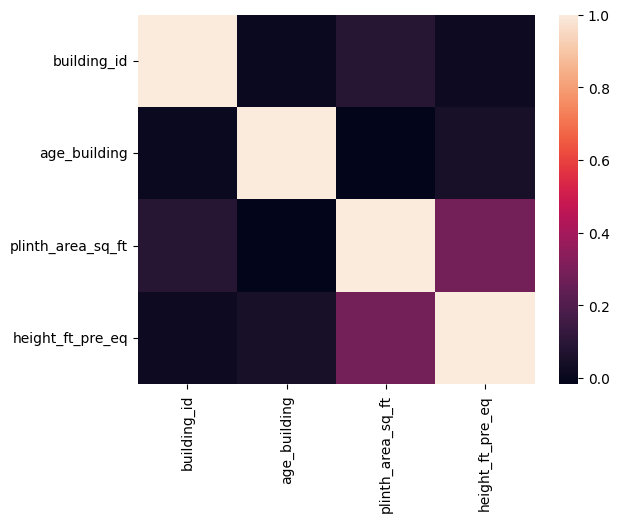

In [78]:
correlation = df.select_dtypes("number").drop(columns="severe_damage").corr().round(4)
sns.heatmap(correlation);

Assert Column drop:

In [79]:
assert (
    "count_floors_pre_eq" not in df.columns
), "Did you drop the `'count_floors_pre_eq'` column?"

Seaborn Boxplot

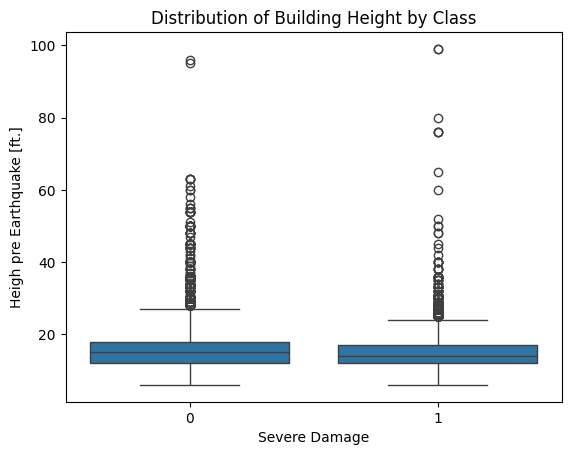

In [88]:
sns.boxplot(x="severe_damage", y="height_ft_pre_eq",data=df)
plt.xlabel("Severe Damage")
plt.ylabel("Heigh pre Earthquake [ft.]")
plt.title("Distribution of Building Height by Class");

Class Balance Bar Chart

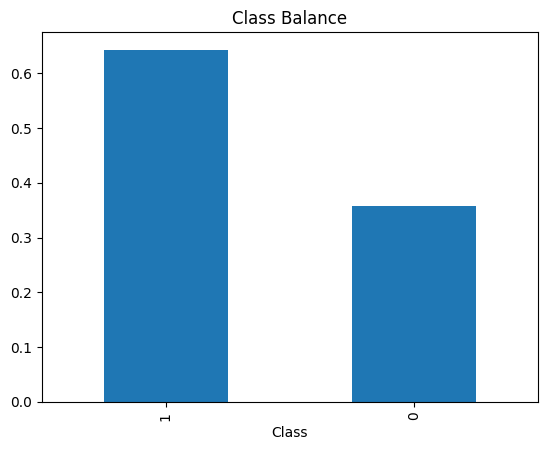

In [89]:
df["severe_damage"].value_counts(normalize=True).plot(
    kind="bar", xlabel="Class", y="Relative Frequency", title="Class Balance"
);

Majority and Minority Classes

In [90]:
majority_class_prop, minority_class_prop = df["severe_damage"].value_counts(normalize=True)
print(majority_class_prop, minority_class_prop)

0.6425969845841097 0.3574030154158902


Assert

In [91]:
assert (
    majority_class_prop < 1
), "`majority_class_prop` should be a floating point number between 0 and 1."
assert (
    minority_class_prop < 1
), "`minority_class_prop` should be a floating point number between 0 and 1."

Pivot Plot

1. A  pivot table


In [96]:
foundation_pivot = pd.pivot_table(
    df, 
    index="foundation_type", 
    values="severe_damage",
    aggfunc=np.mean
).sort_values(by="severe_damage");
foundation_pivot

C:\Users\Asus\AppData\Local\Temp\ipykernel_11104\142659889.py:1: FutureWarning: The provided callable <function mean at 0x000001A81DB9F100> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  foundation_pivot = pd.pivot_table(


,severe_damage
foundation_type,
RC,0.026224
Bamboo/Timber,0.324074
Cement-Stone/Brick,0.421908
Mud mortar-Stone/Brick,0.687792
Other,0.818898


2. Pivot Plot: A bar char for foundation_pivot

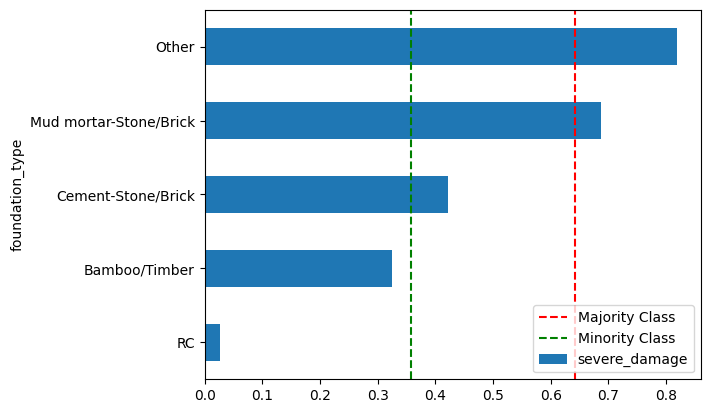

In [97]:
foundation_pivot.plot(kind="barh", legend=None);
plt.axvline(
    majority_class_prop,
    linestyle="--",
    color='red',
    label="Majority Class"
)
plt.axvline(
    minority_class_prop,
    linestyle="--",
    color='green',
    label="Minority Class"
)
plt.legend(loc="lower right");

High Cadinality Features

Check for high and low cardinality categorical variables.

In [98]:
df.select_dtypes("object").nunique()

land_surface_condition     3
foundation_type            5
roof_type                  3
ground_floor_type          5
other_floor_type           4
position                   4
plan_configuration        10
superstructure             7
dtype: int64

In [99]:
df.head()

,building_id,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,superstructure,severe_damage
b_id,,,,,,,,,,,,,
164002,164002,20,560,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Stone,0
164081,164081,21,200,12,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Stone,0
164089,164089,18,315,20,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Stone,0
164098,164098,45,290,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Stone,0
164103,164103,21,230,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Stone,0


In [100]:
df.drop(columns="building_id", inplace=True)
df.head()

,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,superstructure,severe_damage
b_id,,,,,,,,,,,,
164002,20,560,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Stone,0
164081,21,200,12,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Stone,0
164089,18,315,20,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Stone,0
164098,45,290,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Stone,0
164103,21,230,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Stone,0


#### Split

In [104]:
target = "severe_damage"

X = df.drop(columns=target)
y = df[target]

Train-Test Split

In [109]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y, 
    test_size=.2, 
    random_state=42
)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (56668, 11)
y_train shape: (56668,)
X_test shape: (14168, 11)
y_test shape: (14168,)


### Build Model

Base Model: Accuracy score

In [111]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 2))

Baseline Accuracy: 0.64


Iterate: Train logistic regression

In [117]:
# Build model
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    LogisticRegression(max_iter=10000)
)
# Fit model to training data
model.fit(X_train,y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['land_surface_condition',
                                     'foundation_type', 'roof_type',
                                     'ground_floor_type', 'other_floor_type',
                                     'position', 'plan_configuration',
                                     'superstructure'],
                               use_cat_names=True)),
                ('logisticregression', LogisticRegression(max_iter=10000))])

Assertion

In [118]:
# Check your work
assert isinstance(
    model, Pipeline
), f"`model` should be a Pipeline, not type {type(model)}."
assert isinstance(
    model[0], OneHotEncoder
), f"The first step in your Pipeline should be a OneHotEncoder, not type {type(model[0])}."
assert isinstance(
    model[-1], LogisticRegression
), f"The last step in your Pipeline should be LogisticRegression, not type {type(model[-1])}."
check_is_fitted(model)

Evaluate: Accuracy

In [120]:
acc_train = accuracy_score(y_train,model.predict(X_train))
acc_test = model.score(X_test, y_test)

print("Training Accuracy:", round(acc_train, 2))
print("Test Accuracy:", round(acc_test, 2))

Training Accuracy: 0.71
Test Accuracy: 0.72


#### Communicate Results

Predict Probability

In [122]:
y_train_pred_proba = model.predict_proba(X_train)
print(y_train_pred_proba[:5])

[[0.97348824 0.02651176]
 [0.52691683 0.47308317]
 [0.34236157 0.65763843]
 [0.39080644 0.60919356]
 [0.33031427 0.66968573]]


Extract feature names and importances:

In [132]:
encoded_feature_names = model.named_steps['onehotencoder'].get_feature_names_out()
features = encoded_feature_names.tolist()


importances= model.named_steps['logisticregression'].coef_[0]

# importances = {}
# for feature, coef in zip(features, coefficients):
#     importances[feature] = np.abs(coef)

features

In [133]:
features

['age_building',
 'plinth_area_sq_ft',
 'height_ft_pre_eq',
 'land_surface_condition_Steep slope',
 'land_surface_condition_Flat',
 'land_surface_condition_Moderate slope',
 'foundation_type_RC',
 'foundation_type_Mud mortar-Stone/Brick',
 'foundation_type_Bamboo/Timber',
 'foundation_type_Cement-Stone/Brick',
 'foundation_type_Other',
 'roof_type_RCC/RB/RBC',
 'roof_type_Bamboo/Timber-Light roof',
 'roof_type_Bamboo/Timber-Heavy roof',
 'ground_floor_type_RC',
 'ground_floor_type_Mud',
 'ground_floor_type_Timber',
 'ground_floor_type_Brick/Stone',
 'ground_floor_type_Other',
 'other_floor_type_RCC/RB/RBC',
 'other_floor_type_TImber/Bamboo-Mud',
 'other_floor_type_Not applicable',
 'other_floor_type_Timber-Planck',
 'position_Attached-2 side',
 'position_Not attached',
 'position_Attached-1 side',
 'position_Attached-3 side',
 'plan_configuration_Rectangular',
 'plan_configuration_Square',
 'plan_configuration_Others',
 'plan_configuration_H-shape',
 'plan_configuration_T-shape',
 'pla

Importances

In [134]:
importances

array([ 5.95920204e-04,  2.45124837e-04,  6.07028620e-03,  9.64343791e-02,
       -4.46081174e-01, -3.23712103e-01, -1.36440124e+00,  3.66229939e-01,
       -4.04098924e-01, -1.67248113e-01,  8.96159441e-01, -9.94147442e-01,
        9.76942023e-02,  2.23094341e-01, -8.35281785e-01, -1.51997457e-02,
        4.99566503e-01,  1.10967503e-01, -4.33411373e-01, -6.90607308e-01,
       -1.47914986e-01, -7.25164509e-02,  2.37679846e-01,  6.67722513e-03,
       -4.80664198e-02,  3.29841296e-02, -6.64953834e-01,  4.24451631e-01,
        2.96488919e-01, -1.37300422e-01, -6.18032309e-02,  3.14002693e-01,
       -2.74494217e-01, -8.29340774e-01,  3.30741964e-01, -6.30968008e-01,
       -1.05137453e-01, -9.54700088e-02,  1.04467561e+00,  6.49037860e-01,
       -1.57857033e+00, -2.02036219e-02, -1.12529464e-01, -5.60298945e-01])

Sorted Importances

In [135]:
# # Sorted
# sorted_importances=dict(sorted(importances.items(), key=lambda x: x[1], reverse=True))
# sorted_importances

Odds Ratio

Feature Importance

In [140]:
odds_ratios= pd.Series(np.exp(importances), index=features).sort_values()
odds_ratios.head()

superstructure_Other                  0.206270
foundation_type_RC                    0.255534
roof_type_RCC/RB/RBC                  0.370039
ground_floor_type_RC                  0.433752
plan_configuration_Multi-projected    0.436337
dtype: float64

Plot Odds Ratio

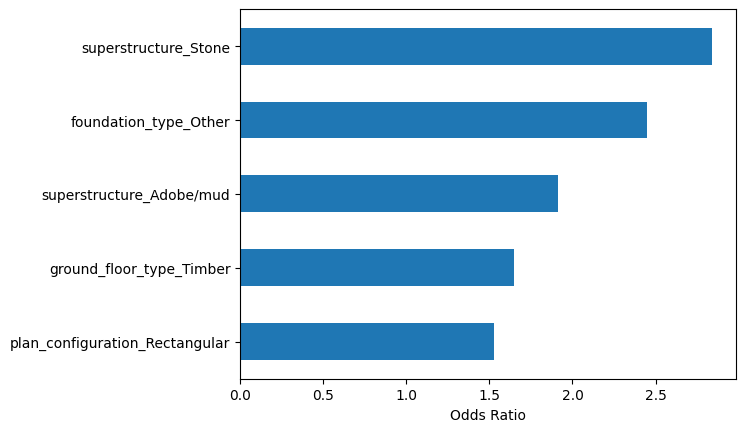

In [141]:
# Horizontal bar chart, five largest coefficients
odds_ratios.tail().plot(kind="barh")
plt.xlabel("Odds Ratio");

Buildings with supstructure_stone are 2.5 times more likely to suffer severe damage.

Plot Odds Ratio II: Horizontal bar chart, five smallest coefficients

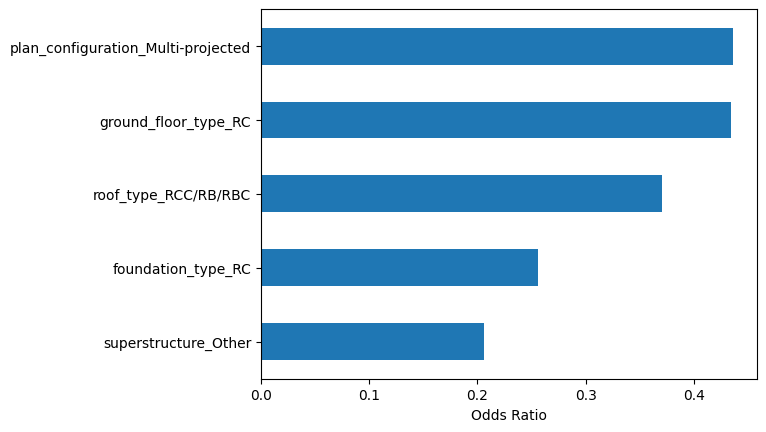

In [143]:
# Horizontal bar chart, five smallest coefficients
odds_ratios.head().plot(kind="barh")
plt.xlabel("Odds Ratio");

Buildings with supersctrures_other are 50% less likely to suffer severe damage.